References:
- https://www.youtube.com/watch?v=HQn1QKQYXVg

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
sequence_length = 4 # length of input sentence, typically set a maximum sequence 
                    # so that all your vectors are goign to be fixed size
batch_size = 1      # going to help with parallel processing
input_dim = 512 # vector dimension of every word that goes into the
                      # Attention Unit
d_model = 512 # output of the Attention Unit for every single word
x = torch.randn( (batch_size, sequence_length, input_dim) ) 
# some randomely sampled input since we're not going to be creating the 
# position encoding in the input phase right now

In [3]:
x.size()
# input is going to be batch_size x sequence_length x input_dim

# Note: x is what goes directly into the Encoder part of the transformer

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)
# now we're going to be mapping the input from this dimension (input_dim) of 
# 512 to  3 times the model dimension (3 * 512)

# this is done to create the Q, K, V vectors all concatenated
# all of them have the 8 attention heads which we will split up later

In [5]:
qkv = qkv_layer(x)
# we pass the input x to this layer to generate the qkv vector

In [6]:
qkv.shape
# it's one batch, 4 words, and each word vector is 1536 in size

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

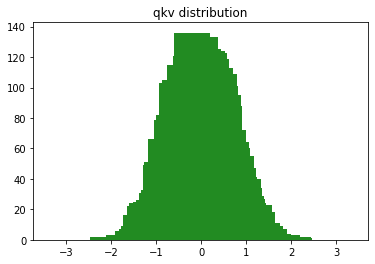

In [7]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

# to get an idea of like what are the kind of values that we
# see here and since I'm sampling from a random normal distribution you'll see
# the values that look like this but this distribution of all the values in 
# this entire tensor is going to be very different depending on how we generate
# the data depending on the positional encodings and the inputs

In [8]:
num_heads = 8 # number of attention heads
head_dim = d_model // num_heads # 512 / 8 = 64

# we will now reshape our qkv
# Matrix to break down the last Dimension
# into a product of the number of heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
# the 3 exists because of the combination of Q, K, V vectors

In [9]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [10]:
# I'm going to be switching around just the second and the third
# Dimensions so that the head is over here and then the number of sequences 
# is over here so it's easier to perform parallel operations on these 
# last two Dimensions
qkv = qkv.permute(0, 2, 1, 3) 
# [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [11]:
# now we obtain the query key and value vectors individually by basically
# breaking down this entire tensor by its last Dimension and 
# hence the input is -1
q, k, v = qkv.chunk(3, dim=-1)
# this is where you see the query key and value Vector is broken down as I
# mentioned before
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

Self Attention for Multiple Heads

In [12]:
d_k = q.size()[-1] # get the size of one of these vectors, should be 64

# every word has a query vector and it's goign to compare its query vector
# to every other words key vector
# and that's represented by this matrix multiplication over here
scaled = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)
# Note: you have to use the transpose function and you can't just do like a
# DOT T to typically transpose because these are tensors that are four
# dimensional and not simply just two-dimensional matrices and so we
# specify the transpose along with the dimensions along which we want to
# transpose in this case we wanted to transpose the last two Dimensions which
# are the (sequence length) as well as the 
# (dimension size or the head Dimension size) for every one of these words 
# in every head and so the last two dimensions of
# the query Vector are like 4x64. this (k.transpose) will be a 64 cross 4 
# and so we'll end with a up with a 4x4 Matrix which is basically the
# sequence length by the sequence length
scaled.shape
# scaling here to make sure the variance of these values is much smaller
# so that these values just don't go out of control

torch.Size([1, 8, 4, 4])

In [13]:
k.T.shape

<ipython-input-13-879c2705464e>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [14]:
# example of transpose
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[ 1.4977,  0.1775],
        [-0.5478, -2.2037],
        [ 0.0158, -1.5107]])

In [15]:
torch.transpose(y, 1, 0)

tensor([[ 1.4977,  0.1775],
        [-0.5478, -2.2037],
        [ 0.0158, -1.5107]])

In [16]:
k.transpose(-1, -2) == k.transpose(-2, -1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

In [17]:
k.transpose(-1, -2).shape

torch.Size([1, 8, 64, 4])

In [18]:
# Masking
# required for self-attention
# this is done to ensure the decoder does not cheat 
# the goal of the attention mechanism is to gain context from the words
# that are around it during the encoding phase, we actually 
# have all words which are passed in in parallel simultaneously 
# so we can generate vectors by taking the context
# of words that come before it as well as words that come after in the decoder

# in the decoder however, we generate words one at a time so when generating
# context, we only want to look at words that come before it because we don't
# event have the words that come after it
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for a single head it'll look like this 

# note: it's the same exact dimension as our scaled vector

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [19]:
(scaled + mask)[0][0] # add them both together

# this is the tensor for one head which will be a 4x4 matrix
# upper diagonal elements would be the negative infinity now
# we're doing negative infinity because we're going to do softmax which takes
# like exponents, the exponents of zero will become one
# the exponents of -infinity will become zero so that you cannot cheat and
# look forward

tensor([[ 0.5910,    -inf,    -inf,    -inf],
        [-0.2502, -0.5378,    -inf,    -inf],
        [-0.2204, -0.0691, -0.6483,    -inf],
        [ 0.1347,  1.1368,  0.2762,  0.1638]], grad_fn=<SelectBackward0>)

In [20]:
scaled += mask

In [21]:
# apply built in softmax function
# and we apply it to the last dimension, which incorporates the row itself
attention = F.softmax(scaled, dim=-1)

In [22]:
attention.shape

torch.Size([1, 8, 4, 4])

In [23]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5714, 0.4286, 0.0000, 0.0000],
        [0.3552, 0.4132, 0.2315, 0.0000],
        [0.1693, 0.4612, 0.1951, 0.1743]], grad_fn=<SelectBackward0>)

In [24]:
# we now take this value vector (v), remember this is what is actually being
# offered by every single word in order to generate new value vectors
values = torch.matmul(attention, v)

# the idea here is that these new value vectors are going to be much more 
# context aware than the original value vectors in the original input

# so we'll end up for every batch, for every head, for every word, in the 
# sequence we'll have a 64 dimensional vector
values.shape

torch.Size([1, 8, 4, 64])

Function

In [25]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [26]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [27]:
attention.shape

torch.Size([1, 8, 4, 4])

In [28]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.5714, 0.4286, 0.0000, 0.0000],
        [0.3552, 0.4132, 0.2315, 0.0000],
        [0.1693, 0.4612, 0.1951, 0.1743]], grad_fn=<SelectBackward0>)

In [29]:
# we can now have all of the value vectors for every single attention head,
# for every single word which are 64 dimensional vectors
values.size()

torch.Size([1, 8, 4, 64])

In [30]:
# combine or concatenate all of those heads together and for eight heads
# we're going to now make them 512 dimensional vectors which is exactly the
# input dimension
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [31]:
# then so that these heads can also communicate with each other the
# information that they've learned we are just going to pass it through a linear
# layer which is just a feed forward layer of 512x512 and this 
# doesn't change the dimension
linear_layer = nn.Linear(d_model, d_model)

In [32]:
out = linear_layer(values)

In [33]:
# this output vector is going the be much more context aware than 
# the input vector was
out.shape

torch.Size([1, 4, 512])

In [34]:
out

tensor([[[-0.0865,  0.2972, -0.1460,  ...,  0.3308, -0.6109, -0.5209],
         [-0.0402,  0.1618, -0.0970,  ...,  0.3004,  0.0423,  0.1351],
         [ 0.0311,  0.0759, -0.1420,  ...,  0.0654,  0.0637, -0.2134],
         [-0.0801, -0.0453,  0.2696,  ...,  0.0900, -0.1515,  0.3044]]],
       grad_fn=<ViewBackward0>)

Class

In [35]:
import torch
import torch.nn as nn

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

Input

In [36]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
